#Football Analysis
###Github Rep: https://github.com/Gvascons/Football-Analysis

Analysis up to 18/07/2022


In [1]:
#!pip install pyspark

In [2]:
%matplotlib inline

#import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.preprocessing import OneHotEncoder

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
attack = pd.read_csv('https://raw.githubusercontent.com/Gvascons/Football-Analysis/main/Project/scrapyTeams/ataque.csv')
defense = pd.read_csv('https://raw.githubusercontent.com/Gvascons/Football-Analysis/main/Project/scrapyTeams/defesa.csv')
goalie = pd.read_csv('https://raw.githubusercontent.com/Gvascons/Football-Analysis/main/Project/scrapyTeams/goleiros.csv')

## Attack

### SPARK APPROACH (OUT OF DATE)

PySpark implementation refers to a different approach that was not incorporated in this document. Feel free to try it out for yourself.

In [5]:
#SPARK APPROACH FROM PD DATAFRAME
"""
from pyspark.sql import SparkSession
spark = SparkSession.builder\
          .appName("SparkApproach")\
          .getOrCreate()
"""

'\nfrom pyspark.sql import SparkSession\nspark = SparkSession.builder          .appName("SparkApproach")          .getOrCreate()\n'

In [6]:
#sparkDF=spark.createDataFrame(attack)

In [7]:
"""
sparkDF.printSchema()
sparkDF.show()
"""

'\nsparkDF.printSchema()\nsparkDF.show()\n'

In [8]:
#sparkDF.select('jogador').show()

### PANDAS APPROACH


### Data Preprocessing & Analysis

#### Type Definition

Our raw dataset includes players in all positions

We have the raw attack dataset

In [9]:
 attack.head(10)

,jogador,nacao,posicao,idade,minPor90,gols,assist
0,Juninho,BRA,LT,34,14.7,0,1
1,Marlon Freitas,BRA,LT,27,15.4,2,3
2,Lucas Kal,BRA,LT,26,13.3,0,0
3,Jefferson,BRA,ZG,25,14.1,1,1
4,Éverson,BRA,G,31,17.0,0,0
5,Kevin,BRA,ZG,24,16.8,1,1
6,Gatito Fernández,PAR,G,34,14.0,0,0
7,Cleiton Schwengber,BRA,G,24,17.0,0,0
8,Cássio,BRA,G,35,15.0,0,0
9,João Ricardo Riedi,BRA,G,33,15.0,0,0


Analyzing the data and checking if there are null values or not


In [10]:
print("ATTACK INFO: ^^^\n", attack.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   jogador   599 non-null    object 
 1   nacao     599 non-null    object 
 2   posicao   599 non-null    object 
 3   idade     599 non-null    int64  
 4   minPor90  599 non-null    float64
 5   gols      599 non-null    int64  
 6   assist    599 non-null    int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 32.9+ KB
ATTACK INFO: ^^^
 None


Looking for some statistic values of our dataset

In [11]:
print("ATTACK DESCRIPTION: \n", attack.describe())

ATTACK DESCRIPTION: 
             idade    minPor90        gols      assist
count  599.000000  599.000000  599.000000  599.000000
mean    26.213689    6.918698    1.761269    1.140234
std      5.215209    5.180080    4.688786    3.124566
min     16.000000    0.000000    0.000000    0.000000
25%     22.000000    2.250000    0.000000    0.000000
50%     25.000000    5.900000    0.000000    0.000000
75%     30.000000   11.000000    1.000000    1.000000
max     41.000000   17.000000   27.000000   22.000000


#### Data Cleaning & Manipulation

Checking for unique values of our column 'posicao'

In [12]:
attack['posicao'].unique()

array(['LT', 'ZG', 'G', 'AT', 'LT,ZG', 'ZG,LT', 'LT,AT', 'AT,LT'],
      dtype=object)

We only want to analyze players regarding attacking positions for now, so we will remove positions not related to 'AT'.


In [13]:
attack.drop(attack[(attack['posicao'] != 'AT') & (attack['posicao'] != 'AT,LT') & (attack['posicao'] != 'LT,AT')].index, inplace=True)

Then, we fix the index.


In [14]:
attack.reset_index(inplace=True)

In [15]:
attack.drop('index',axis=1, inplace=True)
attack.index.name = 'index'

As we can see on the below, our current data contains only the players that are related to attack position.

In [16]:
attack

,jogador,nacao,posicao,idade,minPor90,gols,assist
index,,,,,,,
0,Erison,BRA,AT,23,13.4,6,1
1,Hulk,BRA,AT,35,13.9,7,2
2,Roger Guedes,BRA,AT,25,12.2,5,1
3,Wellington Rato,BRA,"LT,AT",30,13.6,4,0
4,Stiven Mendoza,COL,"AT,LT",30,11.5,7,0
...,...,...,...,...,...,...,...
143,Caio Matheus,BRA,AT,22,17.0,18,12
144,Marlon,BRA,"LT,AT",32,1.7,0,0
145,Vitor Gabriel,BRA,AT,22,4.3,1,0


We treat players that haven't played the same way we would treat players with NULL values. So first, we fill the players stats regarding players that haven't played with NaN values.

In [17]:
attack.loc[attack['minPor90']==0, ['minPor90','gols','assist']] = np.nan

We now have the NaN values for these rows.

In [18]:
# We have the NaN values
attack[attack['minPor90'].isnull()]

,jogador,nacao,posicao,idade,minPor90,gols,assist
index,,,,,,,
65,Rikelmi,BRA,AT,20,NaN,NaN,NaN
127,David,BRA,AT,22,NaN,NaN,NaN
136,Vitor Hugo,BRA,AT,18,NaN,NaN,NaN


We will impute data on our NaN values and we chose the mean() approach to fill them.


In [19]:
attack['minPor90'].fillna(attack['minPor90'].mean(), inplace=True)
attack['gols'].fillna(attack['gols'].mean(), inplace=True)
attack['assist'].fillna(attack['assist'].mean(), inplace=True)

We have the float values regarding goals and assists, so we have to treat them and convert to an integer.

In [20]:
attack[(attack['gols']%1!=0) | (attack['assist']%1!=0)][['jogador','gols','assist']]

,jogador,gols,assist
index,,,
65,Rikelmi,2.248276,1.110345
127,David,2.248276,1.110345
136,Vitor Hugo,2.248276,1.110345


In [21]:
attack['gols'] = attack['gols'].apply(np.floor)
attack['assist'] = attack['assist'].apply(np.floor)

There are no longer "float" values

In [22]:
attack[(attack['gols']%1!=0) | (attack['assist']%1!=0)][['jogador','gols','assist']]

,jogador,gols,assist
index,,,


In [23]:
# As we can see, the value has been updated to it's floor value
attack[attack.index==65]

,jogador,nacao,posicao,idade,minPor90,gols,assist
index,,,,,,,
65,Rikelmi,BRA,AT,20,6.268966,2.0,1.0


We noticed that the Srappy method used to gather our data information included some "wrong" data regarding a few players. Since we already knew that the top scorer of the season was "Germán Cano" (Fluminense), it was easy to decide which players to exclude from our original database.

In [24]:
# Wrong values
attack[attack['gols'] > attack[attack['jogador'] == 'Germán Cano']['gols'].values[0]]

,jogador,nacao,posicao,idade,minPor90,gols,assist
index,,,,,,,
45,Jean Bonora,BRA,AT,19,17.0,17.0,11.0
62,Bruno,BRA,AT,19,17.0,26.0,18.0
64,Pedro Igor,BRA,AT,20,17.0,18.0,14.0
115,Gustavo Nescau,BRA,AT,22,16.0,16.0,10.0
132,Ángelo Henríquez,CHI,AT,28,17.0,19.0,14.0
143,Caio Matheus,BRA,AT,22,17.0,18.0,12.0


In [25]:
# We dropped all players that scored more goals than Germán Cano
attack.drop(attack[attack['gols'] > attack[attack['jogador'] == 'Germán Cano']['gols'].values[0]].index, inplace=True)

In [26]:
# Now our data is correct
attack[attack['gols'] > attack[attack['jogador'] == 'Germán Cano']['gols'].values[0]]

,jogador,nacao,posicao,idade,minPor90,gols,assist
index,,,,,,,


Here, we have already handled NULL values and wrong data, but the index values have not been updated

We can see the "leap" from index 142 to 144

In [27]:
attack

,jogador,nacao,posicao,idade,minPor90,gols,assist
index,,,,,,,
0,Erison,BRA,AT,23,13.4,6.0,1.0
1,Hulk,BRA,AT,35,13.9,7.0,2.0
2,Roger Guedes,BRA,AT,25,12.2,5.0,1.0
3,Wellington Rato,BRA,"LT,AT",30,13.6,4.0,0.0
4,Stiven Mendoza,COL,"AT,LT",30,11.5,7.0,0.0
...,...,...,...,...,...,...,...
142,Óscar Ruiz,PAR,"AT,LT",31,6.3,3.0,0.0
144,Marlon,BRA,"LT,AT",32,1.7,0.0,0.0
145,Vitor Gabriel,BRA,AT,22,4.3,1.0,0.0


In [28]:
# We fix the index
attack.reset_index(inplace=True, drop=True)

And finally, our dataset is ready to use in production.

In [29]:
attack

,jogador,nacao,posicao,idade,minPor90,gols,assist
0,Erison,BRA,AT,23,13.4,6.0,1.0
1,Hulk,BRA,AT,35,13.9,7.0,2.0
2,Roger Guedes,BRA,AT,25,12.2,5.0,1.0
3,Wellington Rato,BRA,"LT,AT",30,13.6,4.0,0.0
4,Stiven Mendoza,COL,"AT,LT",30,11.5,7.0,0.0
...,...,...,...,...,...,...,...
137,Óscar Ruiz,PAR,"AT,LT",31,6.3,3.0,0.0
138,Marlon,BRA,"LT,AT",32,1.7,0.0,0.0
139,Vitor Gabriel,BRA,AT,22,4.3,1.0,0.0
140,Guilherme Parede,BRA,"LT,AT",26,3.1,0.0,1.0


#### Visualization & Normalization

Here is an example of data visualization:

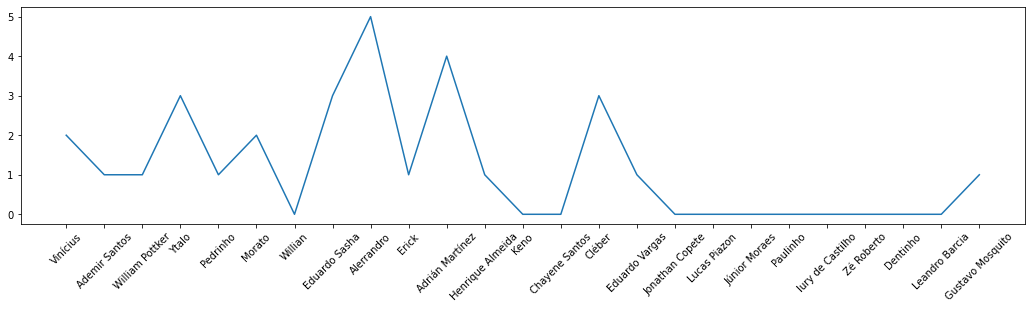

In [30]:
fig = plt.figure(figsize=(18,4))
plt.plot(attack['jogador'][15:40],attack['gols'][15:40])
plt.xticks(rotation=45)
plt.show()

We inserted a new feature based on 2 other features

In [31]:
# Manipulating the data in order to follow with the feature insertion
attack['golsPorPartida'] = (attack['gols']/attack['minPor90'])

In [32]:
attack['golsPorPartida'].head()

0    0.447761
1    0.503597
2    0.409836
3    0.294118
4    0.608696
Name: golsPorPartida, dtype: float64

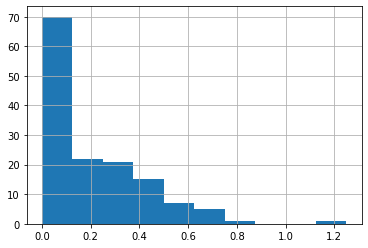

In [33]:
attack['golsPorPartida'].hist()

In [34]:
attack

,jogador,nacao,posicao,idade,minPor90,gols,assist,golsPorPartida
0,Erison,BRA,AT,23,13.4,6.0,1.0,0.447761
1,Hulk,BRA,AT,35,13.9,7.0,2.0,0.503597
2,Roger Guedes,BRA,AT,25,12.2,5.0,1.0,0.409836
3,Wellington Rato,BRA,"LT,AT",30,13.6,4.0,0.0,0.294118
4,Stiven Mendoza,COL,"AT,LT",30,11.5,7.0,0.0,0.608696
...,...,...,...,...,...,...,...,...
137,Óscar Ruiz,PAR,"AT,LT",31,6.3,3.0,0.0,0.476190
138,Marlon,BRA,"LT,AT",32,1.7,0.0,0.0,0.000000
139,Vitor Gabriel,BRA,AT,22,4.3,1.0,0.0,0.232558
140,Guilherme Parede,BRA,"LT,AT",26,3.1,0.0,1.0,0.000000


Here, we can see 2 examples of data visualization regarding:
* The correlation matrix between each feature in out dataset
* A histogram of goals grouped by our age column

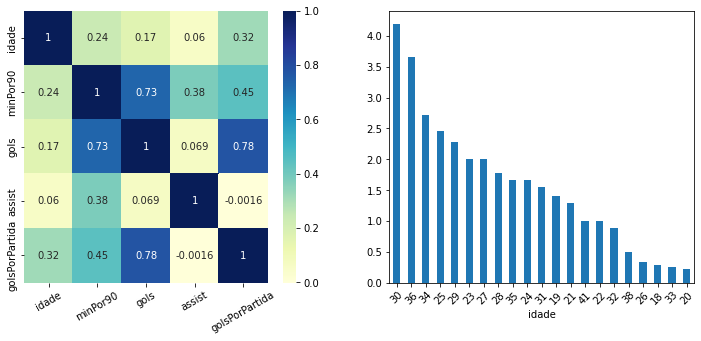

In [35]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121) 
sns.heatmap(data=attack.corr(), cmap="YlGnBu", annot=True)
plt.xticks(rotation=30)
ax2 = plt.subplot(122) 
attack.groupby(['idade'])['gols'].mean().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show()


Here, we can see 2 examples of data visualization regarding:

* A boxplot refering to the distribution of goals
* A countplot of goals regardign the amount of goals

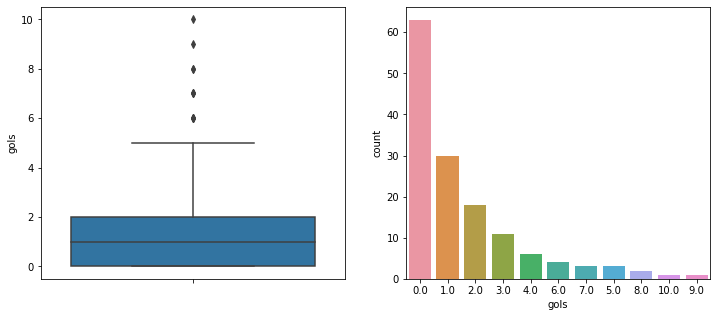

In [36]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
sns.boxplot(y = attack['gols'])
ax1 = plt.subplot(122)
#sns.histplot(data=attack['gols'])
#attack['gols'].plot.hist(sortvalues=True)
sns.countplot(x='gols', data=attack, order=attack['gols'].value_counts().index)
plt.show()

Regarding ***Data Normalization***, we want to present/test two approaches in order to treat our outliers:

##### Log Approach:

In [37]:
attack['gols_log'] = attack['gols'].apply(np.log2)

In [38]:
# Empiric method
for i in range(1):
  attack['gols_log'] = attack['gols_log'].apply(np.log2)

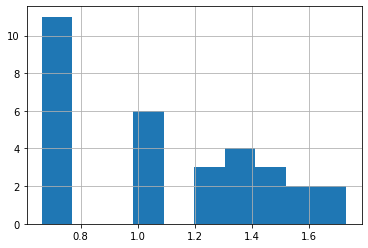

In [39]:
attack[attack['gols_log']>0]['gols_log'].hist()

In [40]:
q1 = attack['gols_log'].quantile(q=0.25)
q3 = attack['gols_log'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)

nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


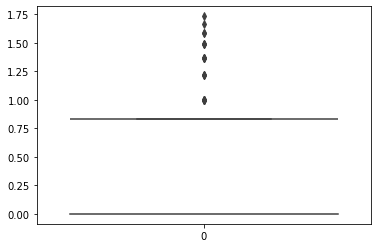

In [41]:
sns.boxplot(data=attack['gols_log'])

In [42]:
#houses[houses['price_log'] < (q1-1.5*iqr)]
attack[attack['gols_log'] > (q3+1.5*iqr)]

,jogador,nacao,posicao,idade,minPor90,gols,assist,golsPorPartida,gols_log


As we can see above, this method is not valid since many players didn't score any goals despite playing. So, it's not an irrelevant value.

##### MinMaxScaler Approach:

In [43]:
# Method change
scaler = MinMaxScaler()
attack['gols_norm'] = scaler.fit_transform(attack[['gols']])
attack['gols_norm'].describe()

count    142.000000
mean       0.153521
std        0.212604
min        0.000000
25%        0.000000
50%        0.100000
75%        0.200000
max        1.000000
Name: gols_norm, dtype: float64

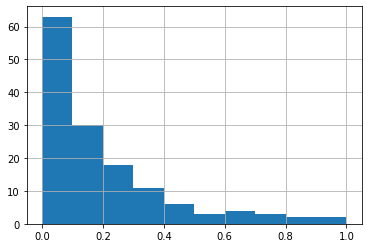

In [44]:
attack['gols_norm'].hist()

In [45]:
q1 = attack['gols_norm'].quantile(q=0.25)
q3 = attack['gols_norm'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)

0.2


In [46]:
attack[attack['gols_norm'] > (q3+1.5*iqr)]

,jogador,nacao,posicao,idade,minPor90,gols,assist,golsPorPartida,gols_log,gols_norm
0,Erison,BRA,AT,23,13.4,6.0,1.0,0.447761,1.370143,0.6
1,Hulk,BRA,AT,35,13.9,7.0,2.0,0.503597,1.489211,0.7
4,Stiven Mendoza,COL,"AT,LT",30,11.5,7.0,0.0,0.608696,1.489211,0.7
5,Guilherme Bissoli,BRA,AT,24,13.5,8.0,0.0,0.592593,1.584963,0.8
12,Léo Gamalho,BRA,AT,36,10.3,6.0,0.0,0.582524,1.370143,0.6
67,Germán Cano,ARG,AT,34,14.9,10.0,1.0,0.671141,1.732021,1.0
72,Pedro Raul,BRA,AT,25,12.4,8.0,0.0,0.645161,1.584963,0.8
77,Jonathan Calleri,ARG,AT,28,15.4,9.0,1.0,0.584416,1.664449,0.9
78,Rony,BRA,AT,27,13.0,7.0,0.0,0.538462,1.489211,0.7
82,Marcos Leonardo,BRA,AT,19,12.9,6.0,1.0,0.465116,1.370143,0.6


In [47]:
best_attack = attack[attack['gols_norm'] > (q3+1.5*iqr)]

In [48]:
best_attack

,jogador,nacao,posicao,idade,minPor90,gols,assist,golsPorPartida,gols_log,gols_norm
0,Erison,BRA,AT,23,13.4,6.0,1.0,0.447761,1.370143,0.6
1,Hulk,BRA,AT,35,13.9,7.0,2.0,0.503597,1.489211,0.7
4,Stiven Mendoza,COL,"AT,LT",30,11.5,7.0,0.0,0.608696,1.489211,0.7
5,Guilherme Bissoli,BRA,AT,24,13.5,8.0,0.0,0.592593,1.584963,0.8
12,Léo Gamalho,BRA,AT,36,10.3,6.0,0.0,0.582524,1.370143,0.6
67,Germán Cano,ARG,AT,34,14.9,10.0,1.0,0.671141,1.732021,1.0
72,Pedro Raul,BRA,AT,25,12.4,8.0,0.0,0.645161,1.584963,0.8
77,Jonathan Calleri,ARG,AT,28,15.4,9.0,1.0,0.584416,1.664449,0.9
78,Rony,BRA,AT,27,13.0,7.0,0.0,0.538462,1.489211,0.7
82,Marcos Leonardo,BRA,AT,19,12.9,6.0,1.0,0.465116,1.370143,0.6


In [49]:
attack.drop(attack[attack['gols_norm'] > (q3+1.5*iqr)].index, inplace=True)

In [50]:
attack

,jogador,nacao,posicao,idade,minPor90,gols,assist,golsPorPartida,gols_log,gols_norm
2,Roger Guedes,BRA,AT,25,12.2,5.0,1.0,0.409836,1.215323,0.5
3,Wellington Rato,BRA,"LT,AT",30,13.6,4.0,0.0,0.294118,1.000000,0.4
6,Vinícius,BRA,"AT,LT",31,11.3,1.0,2.0,0.088496,-inf,0.1
7,Gustavo Mantuan,BRA,"LT,AT",21,9.6,3.0,1.0,0.312500,0.664449,0.3
8,Lima,BRA,"LT,AT",26,10.4,2.0,0.0,0.192308,0.000000,0.2
...,...,...,...,...,...,...,...,...,...,...
137,Óscar Ruiz,PAR,"AT,LT",31,6.3,3.0,0.0,0.476190,0.664449,0.3
138,Marlon,BRA,"LT,AT",32,1.7,0.0,0.0,0.000000,NaN,0.0
139,Vitor Gabriel,BRA,AT,22,4.3,1.0,0.0,0.232558,-inf,0.1
140,Guilherme Parede,BRA,"LT,AT",26,3.1,0.0,1.0,0.000000,NaN,0.0


In [51]:
best_attack.reset_index(drop=True, inplace=True)

In [52]:
attack.reset_index(drop=True, inplace=True)

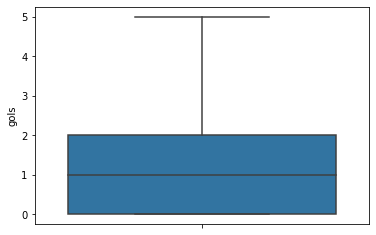

In [53]:
sns.boxplot(y=attack['gols'])

As we can see above, we have seperated our outliers from our original dataset. Therefore, there are no more outliers in our "attack dataset" analysis.  

#### Encoding

Here, we have a OneHotEncoding approach:

In [54]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(attack[['nacao']]).toarray())
enc_df.columns = enc.get_feature_names(['nacao'])
attack_onehot = attack.join(enc_df)
attack_onehot


,jogador,nacao,posicao,idade,minPor90,gols,assist,golsPorPartida,gols_log,gols_norm,...,nacao_ BRA,nacao_ CHI,nacao_ CHN,nacao_ COL,nacao_ ECU,nacao_ ITA,nacao_ PAR,nacao_ UKR,nacao_ URU,nacao_ VEN
0,Roger Guedes,BRA,AT,25,12.2,5.0,1.0,0.409836,1.215323,0.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Wellington Rato,BRA,"LT,AT",30,13.6,4.0,0.0,0.294118,1.000000,0.4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Vinícius,BRA,"AT,LT",31,11.3,1.0,2.0,0.088496,-inf,0.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gustavo Mantuan,BRA,"LT,AT",21,9.6,3.0,1.0,0.312500,0.664449,0.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Lima,BRA,"LT,AT",26,10.4,2.0,0.0,0.192308,0.000000,0.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Óscar Ruiz,PAR,"AT,LT",31,6.3,3.0,0.0,0.476190,0.664449,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
127,Marlon,BRA,"LT,AT",32,1.7,0.0,0.0,0.000000,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,Vitor Gabriel,BRA,AT,22,4.3,1.0,0.0,0.232558,-inf,0.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,Guilherme Parede,BRA,"LT,AT",26,3.1,0.0,1.0,0.000000,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, we have a OrdinalEncoding approach:

In [55]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
attack_onehot2 = attack
attack_onehot2['nacao'] = encoder.fit_transform(attack[['nacao']])
attack_onehot2


,jogador,nacao,posicao,idade,minPor90,gols,assist,golsPorPartida,gols_log,gols_norm
0,Roger Guedes,1.0,AT,25,12.2,5.0,1.0,0.409836,1.215323,0.5
1,Wellington Rato,1.0,"LT,AT",30,13.6,4.0,0.0,0.294118,1.000000,0.4
2,Vinícius,1.0,"AT,LT",31,11.3,1.0,2.0,0.088496,-inf,0.1
3,Gustavo Mantuan,1.0,"LT,AT",21,9.6,3.0,1.0,0.312500,0.664449,0.3
4,Lima,1.0,"LT,AT",26,10.4,2.0,0.0,0.192308,0.000000,0.2
...,...,...,...,...,...,...,...,...,...,...
126,Óscar Ruiz,7.0,"AT,LT",31,6.3,3.0,0.0,0.476190,0.664449,0.3
127,Marlon,1.0,"LT,AT",32,1.7,0.0,0.0,0.000000,NaN,0.0
128,Vitor Gabriel,1.0,AT,22,4.3,1.0,0.0,0.232558,-inf,0.1
129,Guilherme Parede,1.0,"LT,AT",26,3.1,0.0,1.0,0.000000,NaN,0.0


#### Discretization

Here, we have a histogram regarding the attack players ages

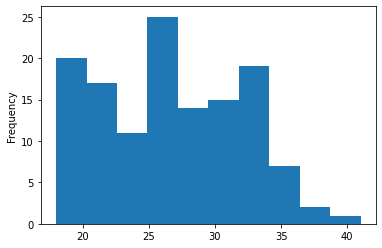

In [56]:
attack['idade'].plot.hist()

If it's in our best interest to discreticize these values into different categories, we have a few approaches:

##### Quantile Approach

In [57]:
# Here, we determine a quartile approach to follow our values segmentation
attack_age_disc_qcut = pd.qcut(attack['idade'], 4)

In [58]:
attack_age_disc_qcut.value_counts()

(17.999, 22.0]    37
(26.0, 31.0]      35
(22.0, 26.0]      30
(31.0, 41.0]      29
Name: idade, dtype: int64

In [59]:
attack_age_disc_qcut.describe()

count                131
unique                 4
top       (17.999, 22.0]
freq                  37
Name: idade, dtype: object

##### Usual Approach

In [60]:
attack_age_disc_cut = pd.cut(attack['idade'], bins=4)

In [61]:
attack_age_disc_cut.value_counts()

(23.75, 29.5]      47
(17.977, 23.75]    40
(29.5, 35.25]      39
(35.25, 41.0]       5
Name: idade, dtype: int64

In [62]:
attack_age_disc_cut.describe()

count               131
unique                4
top       (23.75, 29.5]
freq                 47
Name: idade, dtype: object

### Hypothesis Testing

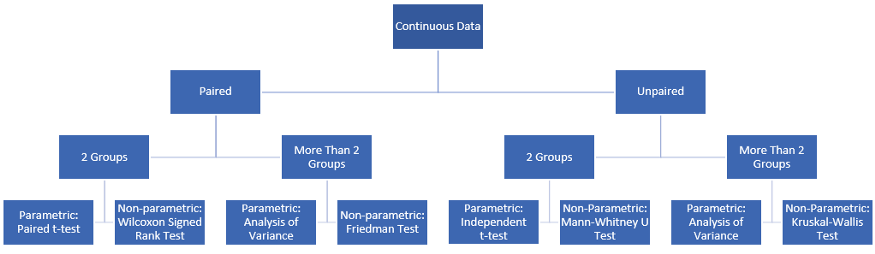

Conduct the hypothesis testing to check whether the amount of goals scored by older players tend to be higher than the amount of goals scored by younger players (using a 0.05 significance level).




To decide whether to use the parametric or nonparametric version of the test, we should check the specific requirements listed below:

* Observations in each sample are independent and identically distributed (IID).
* Observations in each sample are normally distributed.
* Observations in each sample have the same variance.

For that, we have two Hypothesis:
*   Ho -> μy ≤ μo  
*   Ha -> μo > μy

Where μo is the mean of goals scored by older players, and μy is the mean of goals scored by younger players.


Please remember that rejecting H₀ validates H₁. However, failing to reject H₀ does not mean H₀ is valid, nor does it mean H₁ is wrong.

In [63]:
# Our age median is 26
attack['idade'].median()

26.0

In [64]:
# Our age mean is aprox. 26.74
attack['idade'].mean()

26.740458015267176

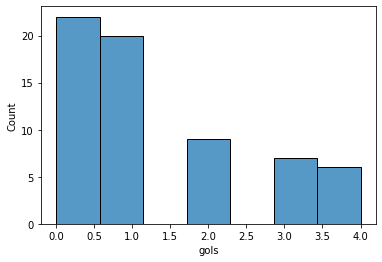

In [65]:
# We have a clue that it's normally distributed (might not be)
sns.histplot(data=attack[attack['idade'] > 26]['gols'])

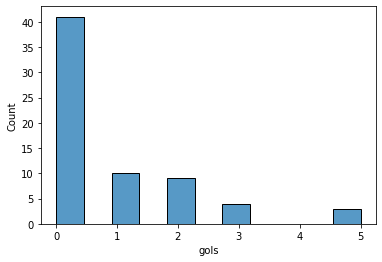

In [66]:
# We have a clue that it's normally distributed (might not be)
sns.histplot(data=attack[attack['idade'] <= 26]['gols'])

In [67]:
def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.10f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

In [68]:
def check_variance_homogeneity(group1, group2):
    test_stat_var, p_value_var= stats.levene(group1,group2)
    print("p value:%.4f" % p_value_var)
    if p_value_var <0.05:
        print("Reject null hypothesis >> The variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis >> The variances of the samples are same.")

In [69]:
older_players_goals = attack[attack['idade'] > 26]['gols']

In [70]:
younger_players_goals = attack[attack['idade'] <= 26]['gols']

CHECKING

H₀: The data is normally distributed.

H₁: The data is not normally distributed.




In [71]:
older_players_goals.count()

64

In [72]:
younger_players_goals.count()

67

In [73]:
check_normality(older_players_goals)

p value:0.0000007537
Reject null hypothesis >> The data is not normally distributed


In [74]:
check_normality(younger_players_goals)

p value:0.0000000001
Reject null hypothesis >> The data is not normally distributed


H₀: The variances of the samples are the same.

H₁: The variances of the samples are different.

In [75]:
check_variance_homogeneity(older_players_goals, younger_players_goals)


p value:0.4067
Fail to reject null hypothesis >> The variances of the samples are same.


There are two groups, and data is collected from different individuals, so it is not paired. However, the normality assumption is not satisfied; therefore, we need to use the nonparametric version of 2 group comparison for unpaired data: the Mann-Whitney U Test.

In [76]:
ttest,pvalue = stats.mannwhitneyu(older_players_goals, younger_players_goals, alternative="greater")
print("p-value:%.10f" % pvalue)
if pvalue <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p-value:0.0036808399
Reject null hypothesis


This means our alternative hypothesis that older players perform better than younger players (regarding the number of goals) is true.

Here is a little hint of why this assumption was chosen:

In [77]:
older_players_goals.mean()

1.296875

In [78]:
younger_players_goals.mean()

0.8208955223880597

# Part 2 (Project 2)

#### Since our data analysis and pre-processing have already been done, now we want to generate inferences over our data. For that, we use 4 different ML models (On SkLearn) in order to gather the best performance results and compare them.

We intend to use 'golsPorPartida' as our dependent variable (to work upon), referring to the average amount of goals scored per match by a specific player.

In [79]:
# using golsPorPartida as our target variable and rest is X variables
X = attack.drop(['golsPorPartida', 'jogador', 'posicao', 'gols_log'], axis=1)
y = attack['golsPorPartida']

# Divide X and y for training and test set and for training set divide it for training and validation set

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Shape of the train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(104, 6)
(27, 6)
(104,)
(27,)


We also intend to use the r2_score as our metric for evaluation

In [80]:
r2_scores_list = {}

Here, we have a Linear Regression Model (native/default).

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R2 score: %.2f" % r2_score(y_test, y_pred))
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))


scores = cross_val_score(lr, X, y, cv=5)
print("Cross-validation scores: {}".format(scores))

R2 score: 0.82
MSE: 0.01
Cross-validation scores: [0.83232632 0.32495272 0.62282945 0.74880356 0.45021638]


In order to gather the best hyper-parameters regarding a certain model, we use Optuna (that performs a combination of the selected hyper-parameters and gather those that performed better when evaluated by our selected score - r2_score)

In [82]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 6.5 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 209 kB 41.3 MB/s 
     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 112 kB 48.8 MB/s 
     |████████████████████████████████| 147 kB 46.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b61d75e2899b54363bc04b5ee679e3f49bb6bf64447a8125be737dbcfaa1dfe2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


We also use mlflow to keep track of the metadata generated in our project.

In [83]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.9 MB 8.9 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 181 kB 53.3 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 147 kB 49.1 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 140 kB 50.2 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.3-py3-none-any.whl size=139102 sha256=6c6521d4c65e8a96defe76a415c2c00debc16510ead901d6ea717cc7eaeeff70
  Stored in directory: /root/.cache/pip/wheels/3f/73/87/c1e4b2145eb6049bb6c9aaf7ea1e38302b77ca219b6fef5d5c
Successfully built databricks-cli
  Attempting uninstall: 

Here, we now apply the optuna framework in our Linear Regression model, in order to select the best hyper-parameters.

In [84]:
import optuna
import mlflow

def objective(trial):
    #Define the parameters
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    normalize = trial.suggest_categorical('normalize', [True, False])
    copy_X = trial.suggest_categorical('copy_X', [True, False])
    n_jobs = trial.suggest_categorical('n_jobs', [None, 1, 2, 3, 4, 5])

    #Define the model
    model = LinearRegression(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)

    #Train the model
    model.fit(X_train, y_train)


    #Predict the model
    y_pred = model.predict(X_test)

    #Calculate the accuracy
    score = r2_score(y_test, y_pred)


    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Use mlflow to log the parameters
mlflow.set_experiment("Linear Regression")
with mlflow.start_run():

    # Log the parameters
    mlflow.log_param("fit_intercept", study.best_params['fit_intercept'])
    mlflow.log_param("normalize", study.best_params['normalize'])
    mlflow.log_param("copy_X", study.best_params['copy_X'])
    mlflow.log_param("n_jobs", study.best_params['n_jobs'])

    # Log the metrics
    mlflow.log_metric("r2_score", study.best_value)

    # Log the model
    mlflow.sklearn.log_model(lr, "model")

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
    

best = study.best_trial.params


[I 2022-10-03 18:01:34,983] A new study created in memory with name: no-name-6eb35aa7-cefa-48ac-85a4-4c8c9817aafa
[I 2022-10-03 18:01:34,994] Trial 0 finished with value: 0.8286942372754351 and parameters: {'fit_intercept': False, 'normalize': True, 'copy_X': False, 'n_jobs': None}. Best is trial 0 with value: 0.8286942372754351.
[I 2022-10-03 18:01:35,002] Trial 1 finished with value: 0.8151742655384873 and parameters: {'fit_intercept': True, 'normalize': False, 'copy_X': False, 'n_jobs': 4}. Best is trial 0 with value: 0.8286942372754351.
[I 2022-10-03 18:01:35,008] Trial 2 finished with value: 0.8286942372754351 and parameters: {'fit_intercept': False, 'normalize': True, 'copy_X': False, 'n_jobs': None}. Best is trial 0 with value: 0.8286942372754351.
[I 2022-10-03 18:01:35,021] Trial 3 finished with value: 0.8151742655384873 and parameters: {'fit_intercept': True, 'normalize': False, 'copy_X': False, 'n_jobs': 3}. Best is trial 0 with value: 0.8286942372754351.
[I 2022-10-03 18:01:

Number of finished trials: 100
Best trial: {'fit_intercept': True, 'normalize': True, 'copy_X': True, 'n_jobs': 1}


In [85]:
lr = LinearRegression(fit_intercept=best['fit_intercept'], normalize=best['normalize'], copy_X=best['copy_X'], n_jobs=best['n_jobs'])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)


print("R2 score: %.2f" % r2_score(y_test, y_pred))
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))

scores = cross_val_score(lr, X, y, cv=5)
print("Cross-validation scores: {}".format(scores))


R2 score: 0.85
MSE: 0.01
Cross-validation scores: [0.83232632 0.32495272 0.62282945 0.74880356 0.45021638]


As we can see. Optuna gathered new hyper-parameters and resulted in a higher R2 SCORE for our model.

We also want to keep track of our models' scores in order, by the end of the analysis, select the one that performed better.

In [86]:
score_lr = r2_score(y_test, y_pred)
r2_scores_list['LinearRegression'] = score_lr

print(r2_scores_list)

{'LinearRegression': 0.8462446940301727}


Here, we have a Decision Tree Regression Model (native/default).

In [87]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

# Train the model
dtr.fit(X_train, y_train)

# Predict the model
y_pred1 = dtr.predict(X_test)

# Calculate the accuracy
print("R2 score: %.2f" % r2_score(y_test, y_pred1))
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))

scores = cross_val_score(dtr, X, y, cv=5)
print("Cross-validation scores: {}".format(scores))

R2 score: 0.87
MSE: 0.01
Cross-validation scores: [0.84900928 0.99980443 0.90202013 0.88642023 0.84642629]


Here, we now apply the optuna framework in our Decision Tree Regression model, in order to select the best hyper-parameters.

In [88]:
def objective_dt(trial):
  criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])
  splitter = trial.suggest_categorical('splitter', ['best', 'random'])

  model = DecisionTreeRegressor(criterion=criterion, splitter=splitter)

  model.fit(X_train, y_train)

  y_pred1 = model.predict(X_test)

  score = r2_score(y_test, y_pred1)

  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=100)

mlflow.set_experiment("Decision Tree Regressor")
with mlflow.start_run():

    # Log the parameters
    mlflow.log_param("criterion", study.best_params['criterion'])
    mlflow.log_param("splitter", study.best_params['splitter'])

    # Log the metrics
    mlflow.log_metric("r2_score", study.best_value)

    # Log the model
    mlflow.sklearn.log_model(dtr, "model")

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
    

best = study.best_trial.params
  

[I 2022-10-03 18:01:39,917] A new study created in memory with name: no-name-a1e83361-9743-4bea-b561-156d0510d545
[I 2022-10-03 18:01:39,930] Trial 0 finished with value: 0.3000057889744472 and parameters: {'criterion': 'poisson', 'splitter': 'best'}. Best is trial 0 with value: 0.3000057889744472.
[I 2022-10-03 18:01:39,938] Trial 1 finished with value: 0.7815962712036411 and parameters: {'criterion': 'squared_error', 'splitter': 'best'}. Best is trial 1 with value: 0.7815962712036411.
[I 2022-10-03 18:01:39,946] Trial 2 finished with value: 0.4526869559770329 and parameters: {'criterion': 'poisson', 'splitter': 'random'}. Best is trial 1 with value: 0.7815962712036411.
[I 2022-10-03 18:01:39,954] Trial 3 finished with value: 0.7487746633427675 and parameters: {'criterion': 'friedman_mse', 'splitter': 'random'}. Best is trial 1 with value: 0.7815962712036411.
[I 2022-10-03 18:01:39,962] Trial 4 finished with value: 0.2903382494979585 and parameters: {'criterion': 'poisson', 'splitter'

Number of finished trials: 100
Best trial: {'criterion': 'squared_error', 'splitter': 'best'}


In [89]:
dtr = DecisionTreeRegressor(criterion=best['criterion'], splitter=best['splitter'])

dtr.fit(X_train, y_train)

y_pred1 = dtr.predict(X_test)

print('R2 score: %.2f' % r2_score(y_test, y_pred1))
print('MSE: %.2f' % mean_squared_error(y_test, y_pred1))

scores1 = cross_val_score(dtr, X, y, cv=5)
print('Cross-validation scores: {}'.format(scores1))


R2 score: 0.87
MSE: 0.01
Cross-validation scores: [0.84204457 0.99980443 0.89907757 0.63491886 0.84642629]


As we can see. Optuna gathered new hyper-parameters and resulted in a higher R2 SCORE for our model.

In [90]:
score_dtr = r2_score(y_test, y_pred1)
r2_scores_list['DecisionTreeRegressor'] = score_dtr

print(r2_scores_list)

{'LinearRegression': 0.8462446940301727, 'DecisionTreeRegressor': 0.8687963073260372}


Here, we have a Gradient Boosting Regression Model (native/default).

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

gbr.fit(X_train, y_train)

y_pred2 = gbr.predict(X_test)

print("R2 score: %.2f" % r2_score(y_test, y_pred))
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))

scores2 = cross_val_score(gbr, X, y, cv=5)

print('Cross-validation scores: {}'.format(scores2))


R2 score: 0.85
MSE: 0.01
Cross-validation scores: [0.87900178 0.90233751 0.9224694  0.94337368 0.84335026]


Now, we apply the optuna framework in our Gradient Boosting Regression model, in order to select the best hyper-parameters.

In [92]:
def objective_gbr(trial):
  loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1.0)
  criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])

  model = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, criterion=criterion)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  score = r2_score(y_test, y_pred)

  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_gbr, n_trials=100)

mlflow.set_experiment("Gradient Boosting Regression")
with mlflow.start_run():
   mlflow.log_param("loss", study.best_params['loss'])
   mlflow.log_param("learning_rate", study.best_params['learning_rate'])
   mlflow.log_param("criterion", study.best_params['criterion'])
   mlflow.log_metric("r2_score", study.best_value)
   mlflow.sklearn.log_model(gbr, "model")

print("Best trial: {}".format(study.best_params))

best = study.best_params

print("Best value: {}".format(study.best_value))


[I 2022-10-03 18:01:43,812] A new study created in memory with name: no-name-b335a930-4fae-448e-ac08-2e32ef01a51a
[I 2022-10-03 18:01:44,077] Trial 0 finished with value: 0.8649519602945162 and parameters: {'loss': 'quantile', 'learning_rate': 0.9327964278151157, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.8649519602945162.
[I 2022-10-03 18:01:44,270] Trial 1 finished with value: 0.8970834130637204 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.9195214457778592, 'criterion': 'squared_error'}. Best is trial 1 with value: 0.8970834130637204.
[I 2022-10-03 18:01:44,539] Trial 2 finished with value: 0.8207375313755325 and parameters: {'loss': 'huber', 'learning_rate': 0.020398605358860282, 'criterion': 'friedman_mse'}. Best is trial 1 with value: 0.8970834130637204.
[I 2022-10-03 18:01:44,763] Trial 3 finished with value: 0.8634755250838536 and parameters: {'loss': 'quantile', 'learning_rate': 0.9634458843298015, 'criterion': 'friedman_mse'}. Best is trial 1

Best trial: {'loss': 'huber', 'learning_rate': 0.2801361479692229, 'criterion': 'squared_error'}
Best value: 0.9522412265715414


In [93]:
best['learning_rate']
print(best['loss'])

huber


In [94]:
gbr = GradientBoostingRegressor(loss=best['loss'], learning_rate=best['learning_rate'], criterion=best['criterion'])

gbr.fit(X_train, y_train)

y_pred2 = gbr.predict(X_test)

print('R2 score : %.2f' % r2_score(y_test, y_pred2))
print('MSE: %.2f' % mean_squared_error(y_test, y_pred2))

scores = cross_val_score(gbr, X, y, cv=5)

print('Cross-validation scores: {}'.format(scores))

R2 score : 0.95
MSE: 0.00
Cross-validation scores: [0.85833324 0.78377199 0.97431537 0.87249681 0.8448878 ]


As we can see. Optuna gathered new hyper-parameters and resulted in a higher R2 SCORE for our model.

In [95]:
score_gbr = r2_score(y_test, y_pred2)
r2_scores_list['GradienBoostRegressor'] = score_gbr

print(r2_scores_list)

{'LinearRegression': 0.8462446940301727, 'DecisionTreeRegressor': 0.8687963073260372, 'GradienBoostRegressor': 0.9472380943459017}


Here, we have a Ada Boosting Regression Model (native/default).

In [96]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor()

abr.fit(X_train, y_train)

y_pred3 = abr.predict(X_test)

print('R2 score: %.2f' % r2_score(y_test, y_pred3))
print('MSE: %.2f' % mean_squared_error(y_test, y_pred3))

scores3 = cross_val_score(dtr, X, y, cv=5)
print('Cross-validation scores: {}'.format(scores3))

R2 score: 0.72
MSE: 0.01
Cross-validation scores: [0.82801289 0.76708187 0.91015035 0.85218815 0.84642629]


Now, we apply the optuna framework in our Gradient Boosting Regression model, in order to select the best hyper-parameters.

In [97]:
def objective_abr(trial):
  learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
  loss = trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])

  model = AdaBoostRegressor(learning_rate=learning_rate, loss=loss)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  score = r2_score(y_test, y_pred)

  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_abr, n_trials=100)

mlflow.set_experiment("AdaBoost Regression")
with mlflow.start_run():
  mlflow.log_param("learning_rate", study.best_params['learning_rate'])
  mlflow.log_param("loss", study.best_params['loss'])

print("Best trial: {}".format(study.best_params))
print("Best value: {}".format(study.best_value))

best = study.best_params



[I 2022-10-03 18:02:26,801] A new study created in memory with name: no-name-389d77bf-f2f2-4ca2-94a5-738d10c0a4e7
[I 2022-10-03 18:02:26,890] Trial 0 finished with value: 0.6836940296504503 and parameters: {'learning_rate': 0.1983015821003992, 'loss': 'exponential'}. Best is trial 0 with value: 0.6836940296504503.
[I 2022-10-03 18:02:26,982] Trial 1 finished with value: 0.7732391731449857 and parameters: {'learning_rate': 0.4283104845954372, 'loss': 'square'}. Best is trial 1 with value: 0.7732391731449857.
[I 2022-10-03 18:02:27,059] Trial 2 finished with value: 0.7071709751120637 and parameters: {'learning_rate': 0.5834175264814799, 'loss': 'linear'}. Best is trial 1 with value: 0.7732391731449857.
[I 2022-10-03 18:02:27,133] Trial 3 finished with value: 0.7223103143777851 and parameters: {'learning_rate': 0.6932370384930036, 'loss': 'square'}. Best is trial 1 with value: 0.7732391731449857.
[I 2022-10-03 18:02:27,213] Trial 4 finished with value: 0.7169093773995001 and parameters: {

Best trial: {'learning_rate': 0.8654140704327042, 'loss': 'square'}
Best value: 0.801484609222773


In [98]:
abr = AdaBoostRegressor(learning_rate=best['learning_rate'], loss=best['loss'])

abr.fit(X_train, y_train)

y_pred3 = abr.predict(X_test)

print('R2 score: %.2f' % r2_score(y_test, y_pred3))
print('MSE: %.2f' % mean_squared_error(y_test, y_pred3))

scores = cross_val_score(abr, X, y, cv=5)

print('Cross-validation scores: {}'.format(scores))

R2 score: 0.78
MSE: 0.01
Cross-validation scores: [0.68248495 0.41782197 0.77777863 0.76788791 0.83020351]


As we can see. Optuna gathered new hyper-parameters and resulted in a higher R2 SCORE for our model.

In [99]:
score_abr = r2_score(y_test, y_pred3)
r2_scores_list['AdaBoostRegressor'] = score_abr

print(r2_scores_list)

{'LinearRegression': 0.8462446940301727, 'DecisionTreeRegressor': 0.8687963073260372, 'GradienBoostRegressor': 0.9472380943459017, 'AdaBoostRegressor': 0.7784119183760005}


Here, we have our best model (according to the R2 SCORE metric and to OPTUNA evaluation for different hyper-parameters).

In [100]:
best_model = max(r2_scores_list, key=r2_scores_list.get)

print(best_model)

r2_scores_list[best_model]

GradienBoostRegressor


0.9472380943459017

We also made a comparison regarding each model quality.

Linear Regression: 0.670058 (0.149289)
DecisionTreeRegressor: 0.899471 (0.145946)
GradientBoostRegressor: 0.909184 (0.090300)
AdaBoostRegressor: 0.738018 (0.199539)


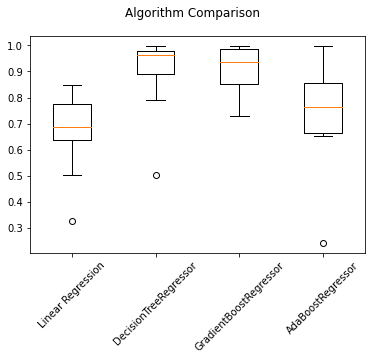

In [101]:
from sklearn.model_selection import KFold

models = []
models.append(('Linear Regression', lr))
models.append(('DecisionTreeRegressor', dtr))
models.append(('GradientBoostRegressor', gbr))
models.append(('AdaBoostRegressor', abr))

results = []
names = []

# from r2_score to compare the models
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare the models
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=45)
plt.show()

In order to get a Disagnostic regarding our best model's performance, we need to analyse it regarding the training set and the test set. 

In [102]:
# Our Best Model
print(best_model)

GradienBoostRegressor


In [103]:
# Related to best model training set
def objective_gbr_for_train(trial):
  loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1.0)
  criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])

  model = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, criterion=criterion)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_train)

  score = r2_score(y_train, y_pred)

  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_gbr_for_train, n_trials=100)

mlflow.set_experiment("Gradient Boosting Regression")
with mlflow.start_run():
   mlflow.log_param("loss", study.best_params['loss'])
   mlflow.log_param("learning_rate", study.best_params['learning_rate'])
   mlflow.log_param("criterion", study.best_params['criterion'])
   mlflow.log_metric("r2_score", study.best_value)
   mlflow.sklearn.log_model(gbr, "model")

print("Best trial: {}".format(study.best_params))

best = study.best_params

print("Best value: {}".format(study.best_value))

[I 2022-10-03 18:02:39,562] A new study created in memory with name: no-name-65164c2f-53db-4356-bdb7-29d43c13592b
[I 2022-10-03 18:02:39,767] Trial 0 finished with value: 0.08484800097996426 and parameters: {'loss': 'quantile', 'learning_rate': 0.013445786524922839, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.08484800097996426.
[I 2022-10-03 18:02:39,954] Trial 1 finished with value: 0.9933400681212651 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.9982894588836029, 'criterion': 'friedman_mse'}. Best is trial 1 with value: 0.9933400681212651.
[I 2022-10-03 18:02:39,995] Trial 2 finished with value: 0.9999986966653455 and parameters: {'loss': 'squared_error', 'learning_rate': 0.4965004135311429, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.9999986966653455.
[I 2022-10-03 18:02:40,306] Trial 3 finished with value: 0.9997887710746283 and parameters: {'loss': 'huber', 'learning_rate': 0.9057238169223836, 'criterion': 'friedman_mse'}. Best is tr

Best trial: {'loss': 'squared_error', 'learning_rate': 0.9082741920319016, 'criterion': 'squared_error'}
Best value: 0.9999999994525685


In [104]:
print(f'Regarding Test Set in the {best_model}: {r2_scores_list[best_model]}')

Regarding Test Set in the GradienBoostRegressor: 0.9472380943459017


In [105]:
y_pred4 = gbr.predict(X_train) 
print(f'Regarding Test Set in the {best_model}: {r2_score(y_train, y_pred4)}')

Regarding Test Set in the GradienBoostRegressor: 0.9995459896186428


As we can see, the chosen model possesses a high performance in both training and test set, which implies that it is indeed a good model for analysis, besides not presenting a high variance.

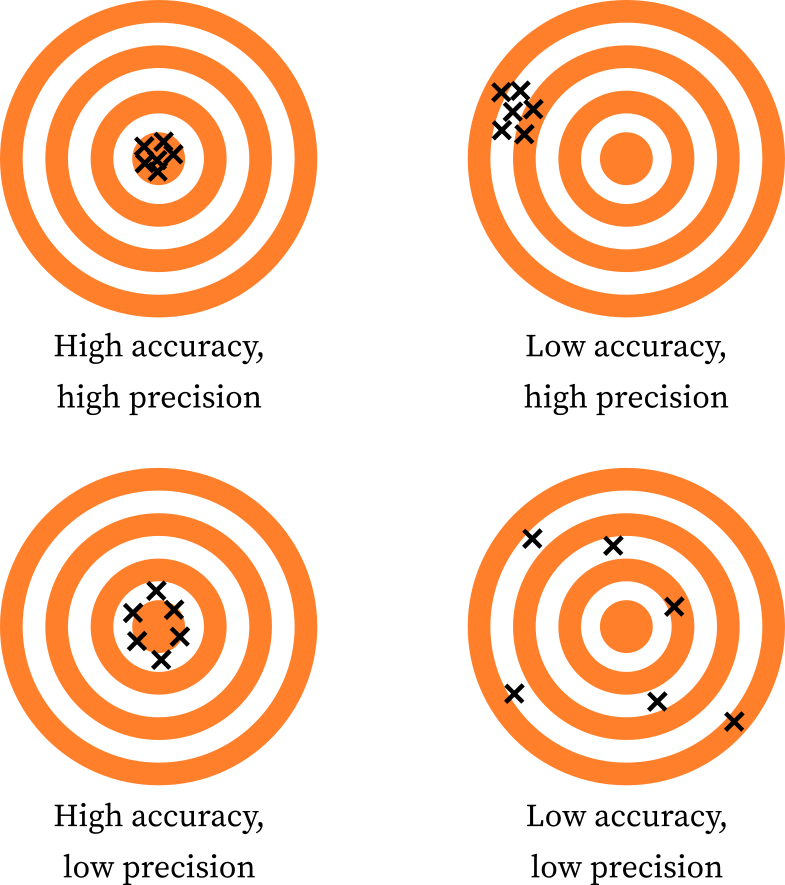

The next cells can be ignored (regarding google collab simultaneous coding).

In [106]:
%%javascript
const listenerChannel = new BroadcastChannel('channel');
listenerChannel.onmessage = (msg) => {
  const div = document.createElement('div');
  div.textContent = msg.data;
  document.body.appendChild(div);
};

<IPython.core.display.Javascript object>

In [107]:
%%javascript
const senderChannel = new BroadcastChannel('channel');
senderChannel.postMessage('Hello world!');

<IPython.core.display.Javascript object>

## Defense

In [108]:
defense.head()

,jogador,nacao,posicao,idade,minPor90,desarmes
0,Juninho,BRA,LT,34,14.7,12
1,Marlon Freitas,BRA,LT,27,15.4,22
2,Éverson,BRA,G,31,17.0,0
3,Kevin,BRA,ZG,24,16.8,21
4,Gatito Fernández,PAR,G,34,14.0,1


## Goalkeeping

In [109]:
goalie.head()

,jogador,nacao,posicao,idade,minPor90,gols_contra,defesas
0,Jailson,BRA,G,40,12.0,13,39
1,Ronaldo,BRA,G,25,15.0,18,52
2,Éverson,BRA,G,31,17.0,17,38
3,Douglas Friedrich,BRA,G,33,10.4,16,24
4,Gatito Fernández,PAR,G,34,14.0,19,47


In [110]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
